<a href="https://colab.research.google.com/github/lowolf25/machine_learning_projects/blob/main/IMDB_SentimentAnalysisModel_with_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Setting Environment:

In [9]:
# Mounting Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Setting toolkit folder as working directory

%cd /content/drive/MyDrive/Colab Notebooks/Project (1) _ Sentiment Analysis Model
! ls

/content/drive/MyDrive/Colab Notebooks/Project (1) _ Sentiment Analysis Model
f1_IMDB_Dataset.csv	    f3_glove.6B.100d.txt	s2_IMDb_Unseen_Predictions.csv
f2_IMDb_Unseen_Reviews.csv  s1_lstm_model_acc_0.865.h5	sentiment_analysis_model.ipynb


In [6]:
# Importing libraries

import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array


from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

## 1. Data Exploration and Preprocessing:

In [12]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("f1_IMDB_Dataset.csv")

In [13]:
movie_reviews.shape

(50000, 2)

In [15]:
movie_reviews.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [16]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<ipython-input-21-56b120ffcbd9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=movie_reviews, palette=['green','red'])


<Axes: xlabel='sentiment', ylabel='count'>

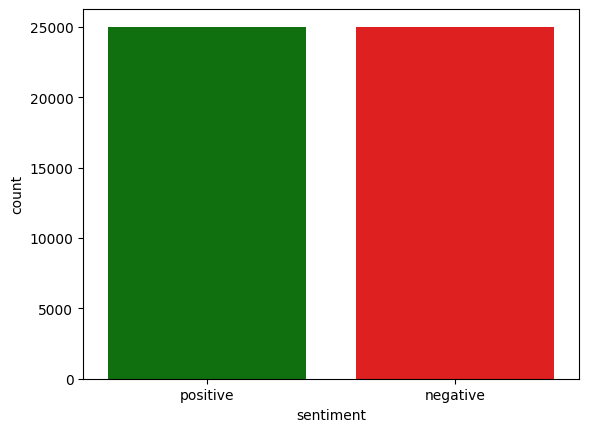

In [21]:
# Observing distribution of positive and negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews, palette=['green','red'])

In [25]:
# Ckecking some sample of reviews in the dataset

movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [31]:
# Building function to Remove HTML tags and replace anything between opening and closing <> with empty space

tag_re = re.compile(r'<[^>]+>')

def remove_tags(text):
    return tag_re.sub('', text)

In [32]:
# Importing package to Remove Stopwords

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
# Data Preprocessing

# Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only in lowercase

def preprocess_text(sen):

    # Convert text to lowercase
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [37]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [38]:
# Sample cleaned up movie review

X[3]

# As Word Embeddings will be used, stemming/lemmatization is not performed in this preprocessing step

'basically family little boy jake thinks zombie closet parents fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first going make film must decide thriller drama drama movie watchable parents divorcing arguing like real life jake closet totally ruins film expected see boogeyman similar movie instead watched drama meaningless thriller spots well playing parents descent dialogs shots jake ignore '

In [39]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [40]:
# Spliting the dataset into training set for model training and testing set for model evaluation.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


## 2. Feature Engineering:

 In this stage, Embedding layer will be built using GloVe word embeddings method which converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [41]:
# Embedding layer in Neural Network expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [42]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [47]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [48]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('f3_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [49]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [50]:
embedding_matrix.shape

(92394, 100)

# 3. Models Training and Evaluation:



## Simple Neural Network

In [51]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [52]:
snn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________


In [53]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [54]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 7ms/step - loss: 0.5588 - acc: 0.7125 - val_loss: 0.5011 - val_acc: 0.7621
Epoch 2/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4487 - acc: 0.7950 - val_loss: 0.4915 - val_acc: 0.7651
Epoch 3/6
250/250 [==============================] - 2s 6ms/step - loss: 0.4134 - acc: 0.8150 - val_loss: 0.4982 - val_acc: 0.7659
Epoch 4/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3913 - acc: 0.8276 - val_loss: 0.5152 - val_acc: 0.7581
Epoch 5/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3745 - acc: 0.8352 - val_loss: 0.5198 - val_acc: 0.7573
Epoch 6/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3643 - acc: 0.8419 - val_loss: 0.5369 - val_acc: 0.7546


In [55]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.5638 - acc: 0.7495


In [56]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5637598633766174
Test Accuracy: 0.7494999766349792


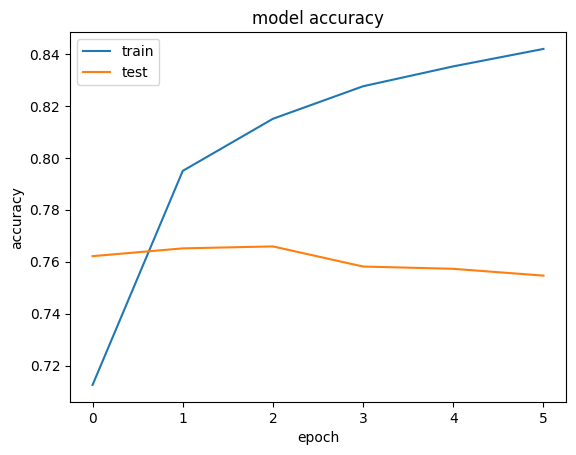

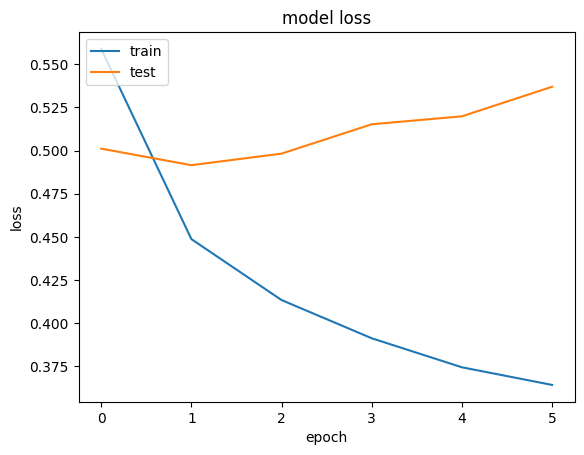

In [57]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [58]:
from keras.layers import Conv1D

In [59]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [60]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [61]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 35s 134ms/step - loss: 0.4683 - acc: 0.7751 - val_loss: 0.3768 - val_acc: 0.8360
Epoch 2/6
250/250 [==============================] - 31s 123ms/step - loss: 0.3350 - acc: 0.8575 - val_loss: 0.3489 - val_acc: 0.8481
Epoch 3/6
250/250 [==============================] - 25s 102ms/step - loss: 0.2824 - acc: 0.8864 - val_loss: 0.4003 - val_acc: 0.8223
Epoch 4/6
250/250 [==============================] - 27s 109ms/step - loss: 0.2371 - acc: 0.9108 - val_loss: 0.3324 - val_acc: 0.8522
Epoch 5/6
250/250 [==============================] - 29s 116ms/step - loss: 0.2003 - acc: 0.9313 - val_loss: 0.3332 - val_acc: 0.8536
Epoch 6/6
250/250 [==============================] - 30s 122ms/step - loss: 0.1631 - acc: 0.9517 - val_loss: 0.3354 - val_acc: 0.8533


In [62]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 4s 12ms/step - loss: 0.3320 - acc: 0.8586


In [63]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.33202826976776123
Test Accuracy: 0.8586000204086304


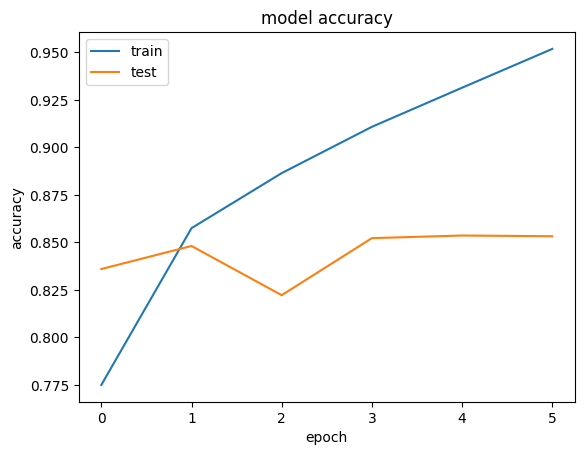

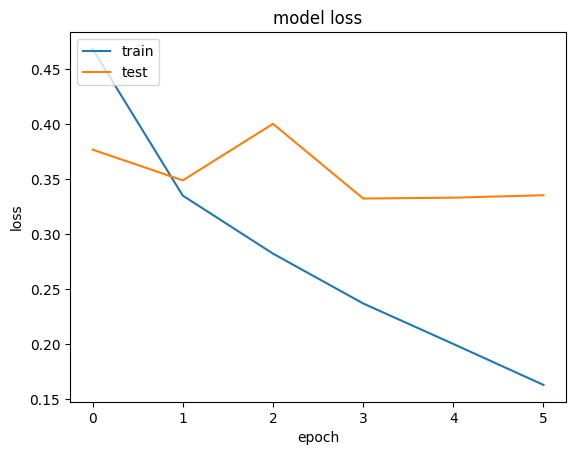

In [64]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [65]:
from keras.layers import LSTM

In [66]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [67]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [68]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 94s 367ms/step - loss: 0.5157 - acc: 0.7452 - val_loss: 0.4237 - val_acc: 0.8105
Epoch 2/6
250/250 [==============================] - 90s 359ms/step - loss: 0.4213 - acc: 0.8104 - val_loss: 0.3797 - val_acc: 0.8306
Epoch 3/6
250/250 [==============================] - 85s 341ms/step - loss: 0.3751 - acc: 0.8369 - val_loss: 0.3393 - val_acc: 0.8525
Epoch 4/6
250/250 [==============================] - 86s 344ms/step - loss: 0.3437 - acc: 0.8519 - val_loss: 0.3325 - val_acc: 0.8601
Epoch 5/6
250/250 [==============================] - 88s 351ms/step - loss: 0.3238 - acc: 0.8634 - val_loss: 0.3174 - val_acc: 0.8650
Epoch 6/6
250/250 [==============================] - 88s 353ms/step - loss: 0.3058 - acc: 0.8757 - val_loss: 0.3123 - val_acc: 0.8671


In [69]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 21s 66ms/step - loss: 0.3137 - acc: 0.8632


In [70]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.31368550658226013
Test Accuracy: 0.8632000088691711


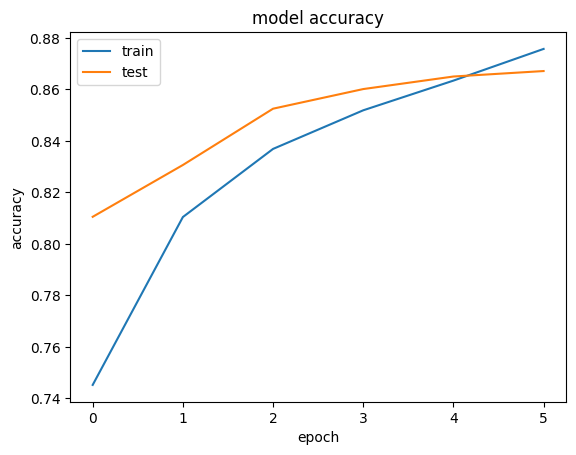

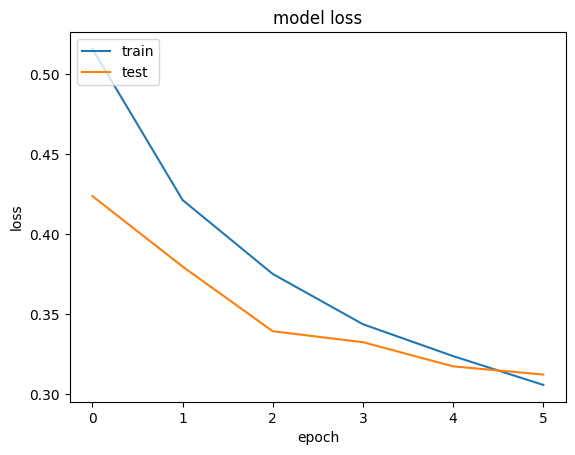

In [71]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [72]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c2_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Making Predictions on Live IMDb data

In [73]:
# lists files in working directory
!ls

c1_lstm_model_acc_0.865.h5  f2_IMDb_Unseen_Reviews.csv	    sentiment_analysis_model.ipynb
c2_lstm_model_acc_0.863.h5  f3_glove.6B.100d.txt
f1_IMDB_Dataset.csv	    s1_IMDb_Unseen_Predictions.csv


In [76]:
# Load previously trained LSTM Model

from keras.models import load_model

model_path ='./c2_lstm_model_acc_0.863.h5'
pretrained_lstm_model = load_model(model_path)

# summarize model.

pretrained_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________


In [78]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("f2_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [79]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [80]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [81]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 534ms/step


array([[0.8113427 ],
       [0.9905725 ],
       [0.27007455],
       [0.29110172],
       [0.9166927 ],
       [0.00816861]], dtype=float32)

In [82]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.1
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,2.7
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,2.9
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.2
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.1


# 4. Model Evaluation

In [84]:
# Make predictions
predicted_sentiments = pretrained_lstm_model.predict(X_test)

# Convert predicted probabilities to binary values
predicted_sentiments = np.round(predicted_sentiments)

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, predicted_sentiments)
precision = precision_score(y_test, predicted_sentiments)
recall = recall_score(y_test, predicted_sentiments)
f1 = f1_score(y_test, predicted_sentiments)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

313/313 [==============================] - 24s 74ms/step
Accuracy: 0.8632
Precision: 0.8530486632044624
Recall: 0.8801349474102005
F1 Score: 0.8663801523735105


<ipython-input-91-8d9a72e373ae>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Accuracy', 'Precision', 'Recall', 'F1 Score'], y=[accuracy, precision, recall, f1], palette='Set2')


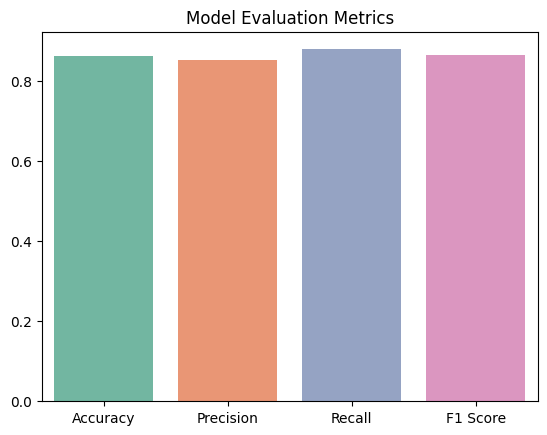

In [91]:
import seaborn as sns

# Create a bar chart of the evaluation metrics
sns.barplot(x=['Accuracy', 'Precision', 'Recall', 'F1 Score'], y=[accuracy, precision, recall, f1], palette='Set2')
plt.title('Model Evaluation Metrics')
plt.show()

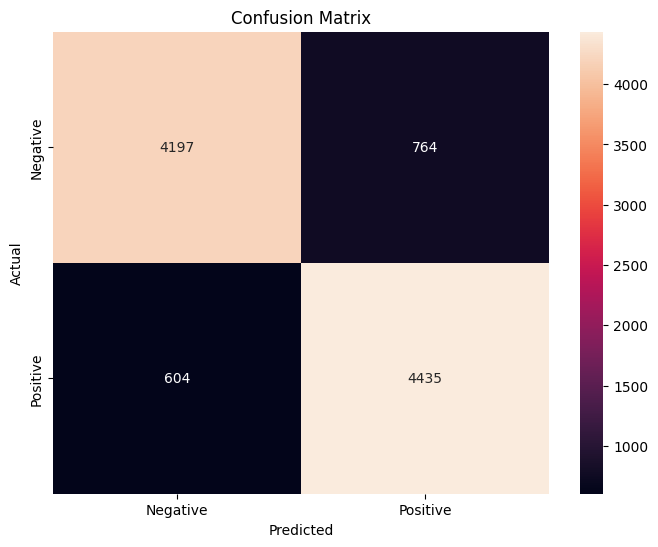

In [92]:
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
cm = confusion_matrix(y_test, predicted_sentiments)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()